<a href="https://colab.research.google.com/github/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Modeling
With our cleaned data in hand, we now want to train some models on our data set. In particular, we want to see how well they can predict drug category based on the processed reports. Precision will be our metric, as we want a model that is able to reproduce similar reports itself.

### Step 1: Importing Libraries
This section is about loading all the necessary libraries to conduct the project.

General Libraries like itertools and re for general programming tasks.
Natural Language Processing Libraries such as nltk and gensim for text processing and modeling.
Machine Learning Libraries like sklearn, tensorflow, xgboost for building, training, and evaluating models.
Data Handling Libraries like numpy, pandas for managing and manipulating data.
Visualization Libraries such as matplotlib, seaborn for creating plots.
Imbalanced Learning Library imblearn to handle imbalanced datasets.
Word Cloud Library wordcloud for visualizing word frequency.

In [1]:
!pip install numpy --upgrade
!pip install lime

import itertools
import re
from ast import literal_eval

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import pickle
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import random
import joblib
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from wordcloud import WordCloud
from xgboost import XGBClassifier
from lime.lime_text import LimeTextExplainer
from random import randint

nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b4e2856a208790817b00589682d8736f143b5bd2934f77d5393330d5e9807dc7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


AttributeError: ignored

## Step 2: Data Loading and Preprocessing
This part loads the dataset and provides information about its structure


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/processed.csv')

df.info()

In [ ]:
lemmatizer = WordNetLemmatizer()

def tokenize_text(text):
    text = text.lower()
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]
    words = [re.sub(r'\W', '', word) for sentence in words for word in sentence]
    words = [lemmatizer.lemmatize(word) for word in words if word]
    return words

df['tokenized_report'] = df['report'].apply(tokenize_text)

In [ ]:
df.head()
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/processed.csv', index=False)

Looks like our data was imported cleanly and has been randomized.

## Data Preperation for Models
Our goal is to train at least three models and that compare which achives the highest precision. Our three models are a logistic regression, a random forest classifier, and an XGBoost model.

We are going to start by creating a Word2Vec model to use in our more complex multiclassifcation problems. Imagine the words in psychedelic trip reports are like ingredients in a complex recipe. Word2Vec helps translate these words into a language that a computer, such as a Random Forest Classifier (RFC), understands. It’s like having a taste expert who knows the flavor of each ingredient (Word2Vec) working with a skilled chef (RFC) to create a dish. Together, they recognize unique flavors and combinations in trip reports, allowing us to identify specific experiences or drug categories more accurately.

In [ ]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return vectorize_reports(X, self.model)

In [ ]:
tokenized_reports = df['tokenized_report'].tolist()

# Train a Word2Vec model
word2vec = Word2Vec(sentences=tokenized_reports, vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
df.head()

,drug,dosage,delivery,weight,gender,report,processed_report,mixed,drug_category,tokenized_report
0,mdpv,NaN,insufflated,140,male,"MDPV, Over a Two-Month PeriodI thought I'd sha...","['mdpv', 'over', 'a', 'twomonth', 'periodi', '...",1,Entactogen/Empathogen,"[mdpv, over, a, twomonth, periodi, thought, i,..."
1,crack,repeated,smoked,165,male,I'll start this story with a bit of background...,"['i', 'll', 'start', 'this', 'story', 'with', ...",0,Stimulant,"[i, ll, start, this, story, with, a, bit, of, ..."
2,methcathinone,10 mg,IV,135,male,I hate the name of this drug. Impossible for m...,"['i', 'hate', 'the', 'name', 'of', 'this', 'dr...",1,Stimulant,"[i, hate, the, name, of, this, drug, impossibl..."
3,jwh-018,,smoked,209,male,"Me - Male (95kg, 29 y/o, moderate experience o...","['me', 'male', '95kg', '29', 'yo', 'moderate',...",1,Cannabinoid,"[me, male, 95kg, 29, yo, moderate, experience,..."
4,pharms - pregabalin,,,170,male,GBL AddictI was thinking of writing this for a...,"['gbl', 'addicti', 'wa', 'thinking', 'of', 'wr...",1,Pharmaceutical,"[gbl, addicti, wa, thinking, of, writing, this..."


In [ ]:
word2vec.save("/content/drive/MyDrive/Colab Notebooks/Data/word2vec_model.model")

The next step sets our dependent and independent variables for our models. Additionally, the target variable (drug_category) is given labels for visualization later. Lastly, since we will be using TF-IDF for our Logistic Regression, and Word2Vec for our RFC and XGB, we've split their X columns appropriately.

In [ ]:
# Define y
y = df['drug_category']

# Encode the labels in y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define X for Logistic Regression as the tokenized reports
X_lr = df['tokenized_report'].apply(' '.join)

# Define X for RFC and XGB as the processed reports
X_rf_xgb = df['processed_report']

## Defining Pipelines
We'll define three pipelines, starting with a Logistic Regression as a baseline, and then Random Forest, and XGBoost to see if we can get imrpovements. Because of our class imbalance, we will include SMOTE for each. While the logistic Regression will use TF-IDF, while Random Forest and XGBoost will later use the Word2Vec we created earlier.

* **TF-IDF**: Helps transform text into a numerical format the model can understand.
* **SMOTE**: Handles class imbalance.

In [ ]:
# Define pipeline for Logistic Regression with TF-IDF
pipeline_lr = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('clf', LogisticRegression(max_iter=500, C=1.0, solver='saga', n_jobs=-1))
])

# Define pipeline for RFC and XGB (SMOTE included; Word2Vec will be applied later)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1))
])

pipeline_xgb = ImbPipeline([
    ('smote', SMOTE()),
    ('clf', XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, eval_metric='mlogloss'))
])

## Data Splitting and Stratification
Next we'll split and stratify the data for the Logistic Regression model. For the Random Forest and XGBoost models, we'll load the Word2Vec-transformed data and stratify that.

In [ ]:
def vectorize_reports(tokenized_reports, word2vec_model):
    vectorized_reports = []
    for report in tokenized_reports:
        # Collect vectors for words that exist in word2vec model
        vectors = [word2vec_model.wv[word] for word in report if word in word2vec_model.wv]
        # If there are no vectors, use a zero vector instead
        if vectors:
            report_vec = np.mean(vectors, axis=0)
        else:
            report_vec = np.zeros(word2vec_model.vector_size) # Make sure this matches the vector size of your model
        vectorized_reports.append(report_vec)
    return np.array(vectorized_reports)

X_word2vec = vectorize_reports(tokenized_reports, word2vec)
X_word2vec = np.vstack(X_word2vec)

In [ ]:
# Split and stratify data for Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Split and stratify data for RFC and XGB
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(X_word2vec, y_encoded))
X_train_w2v, X_test_w2v = X_word2vec[train_index], X_word2vec[test_index]
y_train_w2v, y_test_w2v = y_encoded[train_index], y_encoded[test_index]

## Training, Prediction, and Comparison
Here, we'll train the models, make predictions, and compare the results. This can be done by creating functions train_and_predict and compare_results.

In [ ]:
def train_and_predict(pipeline, X_train, y_train, X_test):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the train and test set
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    return y_train_pred, y_test_pred

def compare_results(model_name, y_train, y_train_pred, y_test, y_test_pred, label_encoder):
    target_names = label_encoder.classes_

    print(f"\n{model_name} - Train Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=1))
    print(f"{model_name} - Test Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=1))


In [ ]:
# Train and Predict for Logistic Regression (LR)
y_train_pred_lr, y_test_pred_lr = train_and_predict(pipeline_lr, X_train_lr, y_train_lr, X_test_lr)
compare_results("Logistic Regression", y_train_lr, y_train_pred_lr, y_test_lr, y_test_pred_lr, label_encoder)

# Train and Predict for Random Forest (RFC)
y_train_pred_rf, y_test_pred_rf = train_and_predict(pipeline_rf, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("Random Forest", y_train_w2v, y_train_pred_rf, y_test_w2v, y_test_pred_rf, label_encoder)

# Train and Predict for XGBoost (XGB)
y_train_pred_xgb, y_test_pred_xgb = train_and_predict(pipeline_xgb, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("XGBoost", y_train_w2v, y_train_pred_xgb, y_test_w2v, y_test_pred_xgb, label_encoder)


Logistic Regression - Train Classification Report:
                       precision    recall  f1-score   support

          Cannabinoid       0.61      0.52      0.56      4622
           Depressant       0.55      0.63      0.59      1809
         Dissociative       0.67      0.88      0.76      2116
Entactogen/Empathogen       0.78      0.85      0.82      5166
            Entheogen       0.74      0.91      0.82      2814
               Opioid       0.74      0.89      0.81      1967
                Other       0.82      0.75      0.78      4999
       Pharmaceutical       0.80      0.78      0.79      5231
          Psychedelic       0.89      0.85      0.87     22690
            Stimulant       0.74      0.74      0.74      2886

             accuracy                           0.80     54300
            macro avg       0.74      0.78      0.75     54300
         weighted avg       0.80      0.80      0.80     54300

Logistic Regression - Test Classification Report:
             

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Data/'


# Logistic Regression (LR) results and model
lr_results_and_model = {
    'y_train_true_lr': y_train_lr,
    'y_train_pred_lr': y_train_pred_lr,
    'y_test_true_lr': y_test_lr,
    'y_test_pred_lr': y_test_pred_lr,
    'lr_model': pipeline_lr,
}

with open(save_path + 'logistic_regression_results_and_model.pkl', 'wb') as file:
    pickle.dump(lr_results_and_model, file)

# Random Forest (RFC) results and model
rf_results_and_model = {
    'y_train_true_rfc': y_train_w2v,
    'y_train_pred_rfc': y_train_pred_rf,
    'y_test_true_rfc': y_test_w2v,
    'y_test_pred_rfc': y_test_pred_rf,
    'rf_model': pipeline_rf,
}

with open(save_path + 'random_forest_results_and_model.pkl', 'wb') as file:
    pickle.dump(rf_results_and_model, file)

# XGBoost (XGB) results and model
xgb_results_and_model = {
    'y_train_true_xgb': y_train_w2v,
    'y_train_pred_xgb': y_train_pred_xgb,
    'y_test_true_xgb': y_test_w2v,
    'y_test_pred_xgb': y_test_pred_xgb,
    'xgb_model': pipeline_xgb,
}

with open(save_path + 'xgboost_results_and_model.pkl', 'wb') as file:
    pickle.dump(xgb_results_and_model, file)

print("Data and models saved successfully!")

Data and models saved successfully!


The categories we are most interested in are 3 (empathogen/entactogen), 4 (entheogen), and 8 (Psychedelics).

And since we were targeting precision, it looks like our logestic regression performed best on the test set and our RFC performed best on the training set, which indicates overfitting. Let's see if we can improve our RFC model with some parameter tuning. We will use GridSearch CV to find the best parameters and then train and test our model with those:

In [ ]:
# Define the parameter grid
param_grid = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5)

print("\nTraining Random Forest with hyperparameter tuning...")
# Perform grid search
grid_search.fit(X_train_w2v, y_train_w2v)

# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

# Predict on the train and test set using the best model
y_train_pred_grid = grid_search.predict(X_train_w2v)
y_test_pred_grid = grid_search.predict(X_test_w2v)

print("Training completed with hyperparameter tuning.")

# Save the trained grid search model
path = "/content/drive/MyDrive/Colab Notebooks/Data/grid_search_rf_model.joblib"
dump(grid_search, path)
print(f"Model saved to {path}")


Training Random Forest with hyperparameter tuning...


In [ ]:
from joblib import load

# Path to the saved model
path = "/content/drive/MyDrive/Colab Notebooks/Data/grid_search_rf_model.joblib"

# Load the model
grid_search_loaded = load(path)

print("Model loaded from", path)


# Generate and print the classification report for both train and test
print("Train Classification Report (with tuning):")
print(classification_report(y_train_w2v, y_train_pred_grid, zero_division=1))
print("Test Classification Report (with tuning):")
print(classification_report(y_test_w2v, y_test_pred_grid, zero_division=1))

Comparing the untuned results to the tuned results shows us that while the tuned results did better on the training data: Entactogen/Empathogen (84/85), Entheogen (83/86), Psychedelic (93/94), they ended up doing worse on our test set (68/61), (63/55), (79/78). So we will stick with our original model to explore the results.

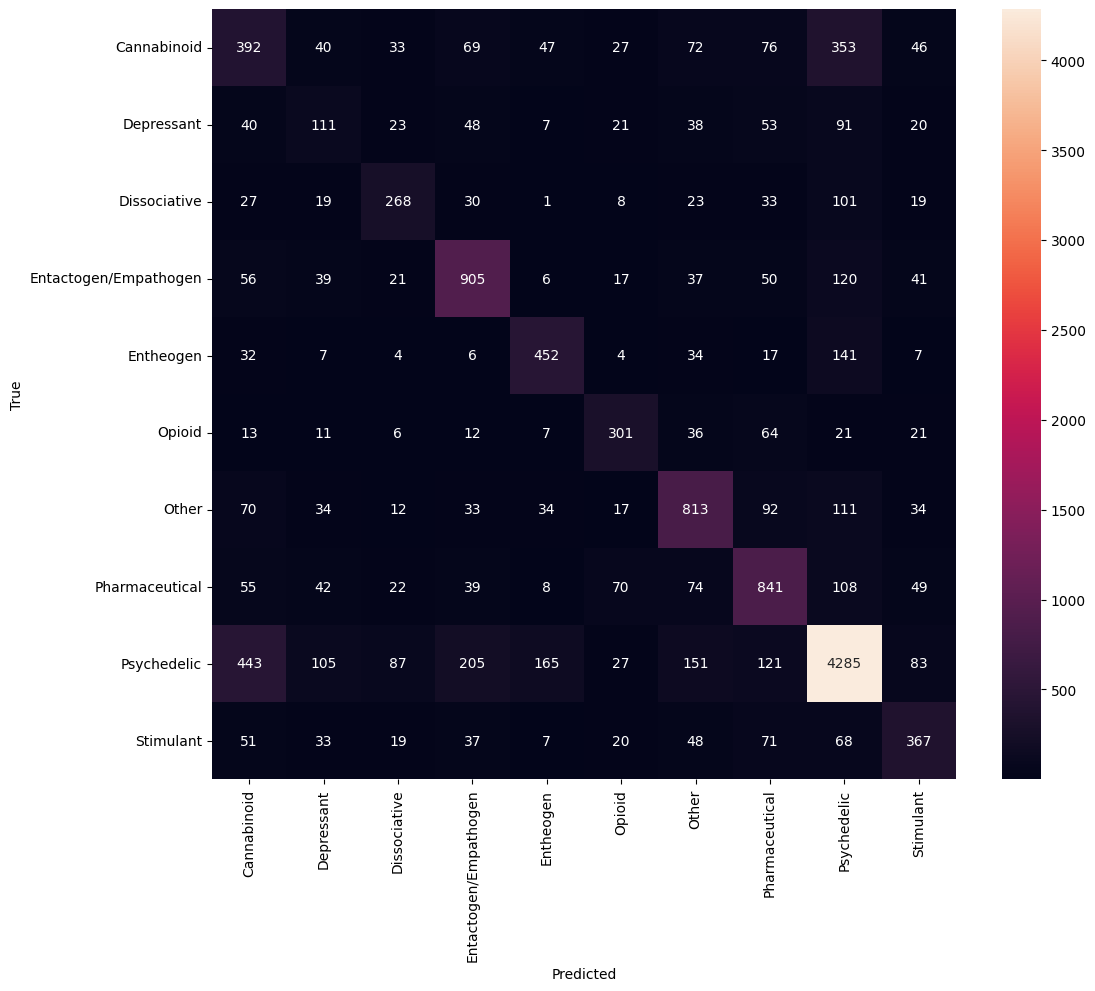

In [ ]:
# Label the categories
encoder = LabelEncoder()
encoder.fit(df['drug_category'])
drug_categories = encoder.classes_

# Generate confusion matrices for test
cm_test = confusion_matrix(y_test_w2v, y_test_pred_rf)

# Plot confusion matrix for test set
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, xticklabels=drug_categories, yticklabels=drug_categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It looks like our model was most likely to label a psychedelic as a cannabinoid, entactogen/empathogen, or an entheogen, and least likely to label it a dissociative, opiod, or stimulat, which is what we would expect! Now let's check out some of the feature importances to see what it is our model thinks is valuable for making its predictions. We will use LIME. To do so, means we need to define a prediction probability function. This function should take a list of texts and return the predicted probabilities for each class for each text. It will use our Word2Vec model and our trained RFC pipeline.

In [ ]:
print(pipeline_rf)

In [ ]:
# Load Word2Vec model
# word2vec_model_path = "/content/drive/MyDrive/Colab Notebooks/Data/word2vec_model.model"
# word2vec = Word2Vec.load(word2vec_model_path)

def preprocess_func(texts):
    transformed_texts = []
    for text in texts:
        # Convert the string representation of the list into an actual list
        processed_report = literal_eval(text)

        # Flatten the list
        processed_report = [word for sublist in processed_report for word in sublist]

        # Convert report into a vector
        report_vec = report_to_vector(processed_report, word2vec)

        transformed_texts.append(report_vec)

    return np.vstack(transformed_texts)

def predict_proba_func(texts):
    def report_to_vector_inner(report, model):
        report_vec = np.zeros(model.vector_size)
        numw = 0
        for word in report:
            try:
                report_vec = np.add(report_vec, model.wv[word])
                numw += 1
            except:
                pass
        return report_vec / numw if numw != 0 else np.zeros(model.vector_size)

    transformed_texts = preprocess_func(texts)
    return pipeline_rf.predict_proba(transformed_texts)


Next we create an explainer using LIME, then choose an instance to explain, and then have the model explain.

In [ ]:
# Initialize a LimeTextExplainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_, split_expression=r'\W+') # Split by words

# Filter the DataFrame to include only rows labeled as 'Psychedelic'
psychedelic_df = df[df['drug_category'] == 'Psychedelic']

# Select a random index from the filtered DataFrame
index_to_explain = randint(0, len(psychedelic_df['processed_report']) - 1)

# Get the processed report at the chosen index
instance = psychedelic_df['processed_report'].iloc[index_to_explain]

# Convert the processed report to a single string
instance_as_string = ' '.join(instance)

# Find the index of 'Psychedelic' in the classes
class_index_to_explain = list(label_encoder.classes_).index('Psychedelic')

# Explain the prediction for the chosen instance, focusing on the class_index_to_explain
explanation = explainer.explain_instance(instance_as_string, predict_proba_func, labels=[class_index_to_explain])

# Show the explanation in the notebook
explanation.show_in_notebook()

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Data/random_forest_results_and_model.pkl"

with open(path, 'rb') as file:
    random_forest_results_and_model = pickle.load(file)

# Extract the RFC model from the loaded results
rf_model = random_forest_results_and_model['rf_model']

# Define a prediction probability function compatible with the RFC model
def predict_proba_func(texts):
    return rf_model.predict_proba(vectorize_reports(texts, word2vec)) # Here we are passing the reports as they are, without splitting by characters

# Initialize a LimeTextExplainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_, split_expression=r'\W+') # Split by words (non-word characters)

# Filter the DataFrame to include only rows labeled as 'Psychedelic'
psychedelic_df = df[df['drug_category'] == 'Psychedelic']

# Select a random index from the filtered DataFrame
index_to_explain = randint(0, len(psychedelic_df['processed_report']) - 1)

# Get the processed report at the chosen index
instance = psychedelic_df['processed_report'].iloc[index_to_explain]

# Convert the processed report to a single string
instance_as_string = ' '.join(instance)

# Find the index of 'Psychedelic' in the classes
class_index_to_explain = list(label_encoder.classes_).index('Psychedelic')

# Explain the prediction for the chosen instance, focusing on the class_index_to_explain
explanation = explainer.explain_instance(instance_as_string, predict_proba_func, labels=[class_index_to_explain])

# Show the explanation in the notebook
explanation.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

In [ ]:
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from random import randint

def lime_tokenizer(text):
    return preprocess_text(text) # Returning words as tokens

def predict_proba_lime(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    vectorized_texts = [report_to_vector(report, word2vec) for report in processed_texts]
    return pipeline_rf.predict_proba(vectorized_texts) # Assuming pipeline_rf is your trained model

# Define the class names and identify the index for 'Psychedelic'
class_names = label_encoder.classes_
class_index_to_explain = list(class_names).index('Psychedelic')

# Initialize the explainer
explainer = LimeTextExplainer(class_names=class_names, split_expression=lime_tokenizer)

# Initialize the explainer
explainer = LimeTextExplainer(class_names=class_names)

# Select a random index from the 'Psychedelic' DataFrame
index_to_explain = randint(0, len(psychedelic_df['processed_report']) - 1)

# Get the processed report at the chosen index and convert it to a single string
text_sample = ' '.join(psychedelic_df['processed_report'].iloc[index_to_explain])

# Explain the instance considering the top 10 contributing words and for all the classes
explanation = explainer.explain_instance(
    text_sample,
    predict_proba_func,
    top_labels=len(class_names), # Here you can set it to the total number of classes or any number that includes your target class
    num_features=10
)

# Plot the explanation for the 'Psychedelic' class
explanation.as_pyplot_figure(label=class_index_to_explain)
plt.show()


In [ ]:
# Create a DataFrame to hold data
error_analysis_df = pd.DataFrame(X_test, columns=feature_names) # assuming feature_names contains your feature names
error_analysis_df['true'] = y_test
error_analysis_df['predicted'] = y_test_pred_rf

# Plot instances where prediction is correct vs incorrect
sns.scatterplot(x='feature1', y='feature2', hue='true', style=(error_analysis_df['true'] == error_analysis_df['predicted']), data=error_analysis_df)
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score

mcc = matthews_corrcoef(y_test, y_test_pred_rf)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred_rf)

print("Matthews correlation coefficient:", mcc)
print("Balanced accuracy score:", balanced_acc)
